## MODELO DE RECOMENDACIÓN DE PRODUCTOS A CLIENTES DE UNA EMPRESA DE VENTA MASIVA

In [1]:
#Librerías
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.metrics.pairwise import cosine_similarity
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer, VectorAssembler
import time

#### Lectura del Dataset

In [1]:
df = pd.read_csv('Origen de datos/data_transaccional_2023.csv')
df.drop('Unnamed: 0.1',axis=1,inplace=True)
df.drop('Unnamed: 0',axis=1,inplace=True)
df

NameError: name 'pd' is not defined

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31816148 entries, 0 to 31816147
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   fec_documento       object 
 1   id_cliente_origen   int64  
 2   id_material_origen  int64  
 3   cod_categoria       float64
 4   des_categoria       object 
 5   tier_product        object 
 6   des_fuerza_venta    object 
 7   ind_autoventa       object 
 8   monto               float64
dtypes: float64(2), int64(2), object(5)
memory usage: 2.1+ GB


DICCIONARIO DE DATOS
<div align="center">
  <img src="https://i.imgur.com/MnaPfrJ.jpeg" width="300" height="400" />
</div>


In [26]:
#Cambio del nombre de las columnas
new_column_names = {
    'fec_documento': 'Fecha',
    'id_cliente_origen': 'ID_Cliente',
    'id_material_origen': 'ID_Producto',
    'cod_categoria': 'ID_Categoria',
    'des_categoria': 'Desc_Categoria',
    'tier_product': 'Calidad_Producto',
    'des_fuerza_venta': 'FuerzaVenta',
    'ind_autoventa': 'Autoventa',
    'monto': 'Monto'
}

df = df.rename(columns=new_column_names)
df

,Fecha,ID_Cliente,ID_Producto,ID_Categoria,Desc_Categoria,Calidad_Producto,FuerzaVenta,Autoventa,Monto
0,2023-04-11,1,1,1.0,Productos para Peinar,NaN,FFVV_1,NaN,22.236297
1,2023-04-28,2,2,2.0,Mantecas,T2,FFVV_2,B,1309.853004
2,2023-04-15,3,2,2.0,Mantecas,T2,FFVV_1,N,6665.729157
3,2023-04-05,4,3,2.0,Mantecas,T2,FFVV_2,N,1043.508855
4,2023-04-24,5,4,2.0,Mantecas,T1,FFVV_3,N,510.083443
...,...,...,...,...,...,...,...,...,...
31816143,2023-09-30,147612,905,49.0,Jabon Liquido,T3,FFVV_3,N,182.190209
31816144,2023-09-11,22647,902,49.0,Jabon Liquido,T3,FFVV_10,N,73.404349
31816145,2023-09-20,24649,901,49.0,Jabon Liquido,T3,FFVV_5,N,22.604854
31816146,2023-09-05,112578,902,49.0,Jabon Liquido,T3,FFVV_9,N,24.877625


In [27]:
df.isnull().sum()

Fecha                      0
ID_Cliente                 0
ID_Producto                0
ID_Categoria             147
Desc_Categoria           147
Calidad_Producto     3589141
FuerzaVenta              317
Autoventa           11106681
Monto                      0
dtype: int64

In [28]:
#Cambio de tipos de Datos e imputación básica
df['ID_Cliente'] = df['ID_Cliente'].astype('category')
df['ID_Producto'] = df['ID_Producto'].astype('category')
df['ID_Categoria'] = df['ID_Categoria'].fillna(0)
df['Autoventa'] = df['Autoventa'].fillna('N')
df['Calidad_Producto'] = df['Calidad_Producto'].fillna('T0')
df['FuerzaVenta'] = df['FuerzaVenta'].fillna('FFVV_0')
df.dropna(subset=['Desc_Categoria'], inplace=True)
df['ID_Categoria'] = df['ID_Categoria'].astype(int)
df['ID_Categoria'] = df['ID_Categoria'].astype('category')
df['Desc_Categoria'] = df['Desc_Categoria'].astype('category')
df['Fecha'] = pd.to_datetime(df['Fecha'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31816001 entries, 0 to 31816147
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Fecha             datetime64[ns]
 1   ID_Cliente        category      
 2   ID_Producto       category      
 3   ID_Categoria      category      
 4   Desc_Categoria    category      
 5   Calidad_Producto  object        
 6   FuerzaVenta       object        
 7   Autoventa         object        
 8   Monto             float64       
dtypes: category(4), datetime64[ns](1), float64(1), object(3)
memory usage: 1.7+ GB


In [29]:
#Cantidad Únicas
DictDescript={
    'Productos': df["ID_Producto"].nunique(),
    'Clientes': df["ID_Cliente"].nunique(),
    'Categorías': df["ID_Categoria"].nunique(),
}

DictDescript

{'Productos': 1359, 'Clientes': 184685, 'Categorías': 52}

In [30]:
#Data lista para ser utilizada
df.isnull().sum()

Fecha               0
ID_Cliente          0
ID_Producto         0
ID_Categoria        0
Desc_Categoria      0
Calidad_Producto    0
FuerzaVenta         0
Autoventa           0
Monto               0
dtype: int64

In [36]:
df

,Fecha,ID_Cliente,ID_Producto,ID_Categoria,Desc_Categoria,Calidad_Producto,FuerzaVenta,Autoventa,Monto
0,2023-04-11,1,1,1,Productos para Peinar,T0,FFVV_1,N,22.236297
1,2023-04-28,2,2,2,Mantecas,T2,FFVV_2,B,1309.853004
2,2023-04-15,3,2,2,Mantecas,T2,FFVV_1,N,6665.729157
3,2023-04-05,4,3,2,Mantecas,T2,FFVV_2,N,1043.508855
4,2023-04-24,5,4,2,Mantecas,T1,FFVV_3,N,510.083443
...,...,...,...,...,...,...,...,...,...
31816143,2023-09-30,147612,905,49,Jabon Liquido,T3,FFVV_3,N,182.190209
31816144,2023-09-11,22647,902,49,Jabon Liquido,T3,FFVV_10,N,73.404349
31816145,2023-09-20,24649,901,49,Jabon Liquido,T3,FFVV_5,N,22.604854
31816146,2023-09-05,112578,902,49,Jabon Liquido,T3,FFVV_9,N,24.877625


### Descripción de los datos

In [9]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()

,Monto
count,31816001.000
mean,485.460
std,2901.224
min,0.061
25%,45.148
50%,108.909
75%,269.477
max,1390220.999


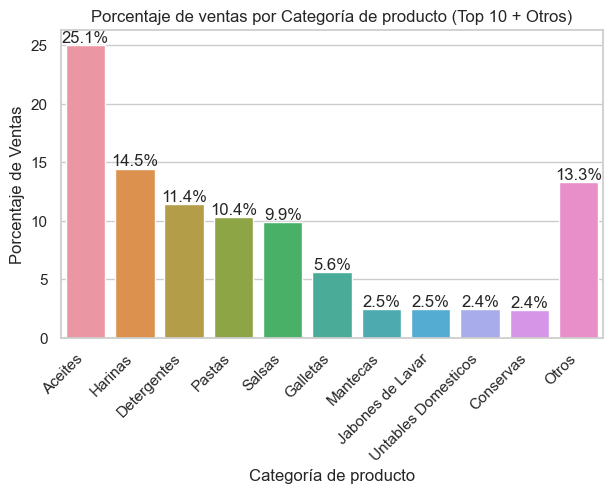

In [10]:
# Supongamos que quieres analizar los porcentajes de ventas por 'Desc_Categoria'
grouped_data = df.groupby('Desc_Categoria')['Monto'].sum().reset_index()
total_ventas = grouped_data['Monto'].sum()
grouped_data['porcentaje'] = (grouped_data['Monto'] / total_ventas) * 100

# Ordenar por porcentaje descendente
grouped_data = grouped_data.sort_values(by='porcentaje', ascending=False)

# Seleccionar los 10 principales
top_10 = grouped_data.head(10)

# Crear la categoría "Otros"
otros = grouped_data.iloc[10:].copy()
porcentaje_otros = otros['porcentaje'].sum()
df_otros = pd.DataFrame({'Desc_Categoria': ['Otros'], 'porcentaje': [porcentaje_otros]})

# Combinar los datos
grouped_data_final = pd.concat([top_10, df_otros])

# Gráfico de barras con Seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 4))
ax = sns.barplot(x='Desc_Categoria', y='porcentaje', data=grouped_data_final)
plt.title('Porcentaje de ventas por Categoría de producto (Top 10 + Otros)')
plt.xlabel('Categoría de producto')
plt.ylabel('Porcentaje de Ventas')
plt.xticks(rotation=45, ha="right")

# Mostrar valores en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()


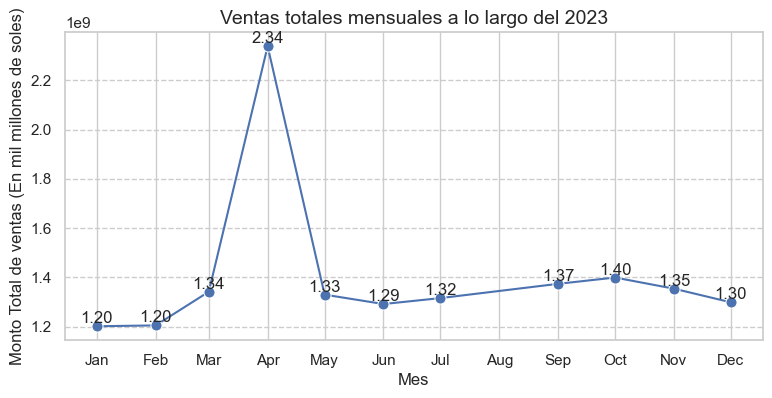

In [11]:
df['Mes'] = df['Fecha'].dt.to_period('M')
ventas_por_mes = df.groupby('Mes')['Monto'].sum().reset_index()

# Convertir el índice de período a marca de tiempo para el gráfico
ventas_por_mes['Mes'] = ventas_por_mes['Mes'].dt.to_timestamp()

plt.figure(figsize=(9, 4))
sns.lineplot(x='Mes', y='Monto', data=ventas_por_mes, marker='o', markersize=8)
plt.title('Ventas totales mensuales a lo largo del 2023', fontsize=14)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Monto Total de ventas (En mil millones de soles)', fontsize=12)  # Etiqueta actualizada

# Formatear el eje X para mostrar solo los nombres de los meses
plt.xticks(pd.date_range(ventas_por_mes['Mes'].min(), ventas_por_mes['Mes'].max(), freq='MS'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.grid(axis='y', linestyle='--')

# Agregar etiquetas a cada punto (en millones)
for x, y in zip(ventas_por_mes['Mes'], ventas_por_mes['Monto']):
    plt.text(x, y, f'{y/1e9:.2f}', ha='center', va='bottom')  # Mostrar en millones

plt.show()

### Reportes Solicitados por el equipo de Web

In [12]:
df_usuarios = pd.DataFrame({'ID_Cliente': df['ID_Cliente'].unique()})

# Crear columnas Usuario y Contraseña
df_usuarios['Usuario'] = 'Usuario' + df_usuarios['ID_Cliente'].astype(str)
df_usuarios['Contraseña'] = df_usuarios['Usuario']

df_usuarios.to_csv('usuarios.csv', index=False)

In [13]:
# Eliminar duplicados basados en ID_Producto
df_productos_unicos = df[['ID_Producto', 'ID_Categoria', 'Desc_Categoria']].drop_duplicates(subset='ID_Producto')

# Imprimir el DataFrame resultante
df_productos_unicos.to_csv('productos.csv', index=False)

In [41]:
df.to_csv('DataProcesada.csv', index=False)

In [48]:
df

,Fecha,ID_Cliente,ID_Producto,ID_Categoria,Desc_Categoria,Calidad_Producto,FuerzaVenta,Autoventa,Monto
0,2023-04-11,1,1,1,Productos para Peinar,T0,FFVV_1,N,22.236297
1,2023-04-28,2,2,2,Mantecas,T2,FFVV_2,B,1309.853004
2,2023-04-15,3,2,2,Mantecas,T2,FFVV_1,N,6665.729157
3,2023-04-05,4,3,2,Mantecas,T2,FFVV_2,N,1043.508855
4,2023-04-24,5,4,2,Mantecas,T1,FFVV_3,N,510.083443
...,...,...,...,...,...,...,...,...,...
31816143,2023-09-30,147612,905,49,Jabon Liquido,T3,FFVV_3,N,182.190209
31816144,2023-09-11,22647,902,49,Jabon Liquido,T3,FFVV_10,N,73.404349
31816145,2023-09-20,24649,901,49,Jabon Liquido,T3,FFVV_5,N,22.604854
31816146,2023-09-05,112578,902,49,Jabon Liquido,T3,FFVV_9,N,24.877625


### Modelo de recomendación

In [2]:
spark = SparkSession.builder \
    .appName("Recomendata") \
    .config("spark.executor.memory", "5g") \
    .config("spark.driver.memory", "5g") \
    .getOrCreate()
spark

In [3]:
# Cargar los datos en un DataFrame de Spark
data = spark.read.csv("DataProcesada.csv", header=True)

In [4]:
# Filtrar columnas relevantes
data_filtered = data.select('ID_Cliente', 'ID_Producto', 'Monto')

# Convertir las columnas a los tipos adecuados
data_filtered = data_filtered.withColumn("ID_Cliente", data_filtered["ID_Cliente"].cast("int"))
data_filtered = data_filtered.withColumn("ID_Producto", data_filtered["ID_Producto"].cast("int"))
data_filtered = data_filtered.withColumn("Monto", data_filtered["Monto"].cast("float"))

In [5]:
# Configurar el modelo ALS
als = ALS(maxIter=5, regParam=0.01, userCol="ID_Cliente", itemCol="ID_Producto", ratingCol="Monto", coldStartStrategy="drop")

# Mecanismo de reintento
max_retries = 3
retry_delay = 5  # segundos

for attempt in range(max_retries):
    try:
        # Entrenar el modelo ALS
        model = als.fit(data_filtered)
        print("Model trained successfully.")
        break
    except Exception as e:
        print(f"Attempt {attempt + 1} failed: {e}")
        if attempt < max_retries - 1:
            print(f"Retrying in {retry_delay} seconds...")
            time.sleep(retry_delay)
        else:
            print("Max retries reached. Exiting.")
            raise

Model trained successfully.


In [10]:
# Obtener recomendaciones para todos los usuarios
user_recommendations = model.recommendForAllUsers(10)

# Mostrar recomendaciones para el usuario con ID 1
user_id = 4
recommendations = user_recommendations.filter(user_recommendations['ID_Cliente'] == user_id).collect()

# Mostrar las recomendaciones
for rec in recommendations:
    print(f"Recomendaciones para el cliente {user_id}: {[r.ID_Producto for r in rec.recommendations]}")

Recomendaciones para el cliente 4: [236, 266, 1030, 257, 256, 261, 255, 1026, 244, 247]
